# Origin Destinations nXn Matrix given set of origins and destinations


The [Origin Destination(OD) Cost Matrix service](http://desktop.arcgis.com/en/arcmap/latest/extensions/network-analyst/od-cost-matrix.htm) helps you to create an OD cost matrix for multiple `origins` to multiple `destinations`. An OD cost matrix is a table that contains cost, such as travel time or travel distance, from each origin to each destination. Additionally, it ranks the destinations in ascending order based on the minimum cost required to travel. When generating an OD cost matrix, you can optionally specify the maximum number of destinations to find for each origin and the maximum time or distance to travel when searching for destinations.

By default, the matrix is generated with columns - origin id, destination id, destination rank, total time and total distance. 
In this sample notebook , we will use this tool to get OD matrix if given a set of origin and destination points, either as a csv with latitude and longitude or csv file with list of addresses. In later part of this sample, we will format the table to get n by n matrix.

This is useful when you want to solve other transportation problems with open source tools or heuristics. When it comes to real world TSP(Travelling Salesman Problem) or VRP(Vehicle Routing Problem) or other tranportation problems, data about travel time from every point to every other point can give you more realistic results than with euclidean distance.

**Note** :If you run the tutorial using ArcGIS Online, 0.003 [credit](http://pro.arcgis.com/en/pro-app/tool-reference/appendices/geoprocessing-tools-that-use-credits.htm#ESRI_SECTION2_5FAF16DB9F044F78AF164A22752A9A7F) will be consumed as there are 6 origin-destination pairs.

As a first step, let's import required libraries and establish a connection to your organization which could be an ArcGIS Online organization or an ArcGIS Enterprise. If you dont have an account, [try this](https://www.esri.com/en-us/arcgis/trial).

In [1]:
import arcgis
from arcgis.gis import GIS
import pandas as pd
import datetime
import getpass
from IPython.display import HTML

from arcgis import geocoding
from arcgis.features import Feature, FeatureSet

In [2]:
portal_url = 'https://wwww.arcgis.com'
#connect to your GIS
user_name = 'arcgis_python' # <user_name>
password = 'P@ssword123' #<password>
my_gis = GIS(portal_url, user_name, password)

We will see how to create layer for origin and destination when we have a csv file with latitude and longitude and when we have addresses to geocode to convert to layer respectively.

In [3]:
# Read csv files from data:
origins_latlong = r"data/origins_latlong.csv"
destinations_address = r"data/destinations_address.csv"

## Create origins layer:

We have latitude and longitude information for origins, with the following code snippet we can create a layer from the information. We reverse geocode the lat long information to find the locations.

**Note**: Geocoding the addresses will consume credits.

In [4]:
origin_coords = ['-117.187807, 33.939479', '-117.117401, 34.029346']
origin_features = []
index = 1
for origin in origin_coords:
    reverse_geocode = geocoding.reverse_geocode({"x": origin.split(',')[0], 
                                              "y": origin.split(',')[1]})    

    origin_feature = Feature(geometry=reverse_geocode['location'], 
                           attributes=reverse_geocode['address'])
    #Assign name to origins 
    origin_feature.attributes['Name']="Origin {}".format(index)    
    origin_features.append(origin_feature)
    index = index + 1

origin_fset = FeatureSet(origin_features, geometry_type='esriGeometryPoint',
                          spatial_reference={'latestWkid': 4326})
origin_fset

<FeatureSet> 2 features

## Create destinations layer:

We have address information for the destination, with the following code snippet to we can geocode the addresses to create destination layer. You could [batch geocode](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.geocoding.html#batch-geocode) the addresses if you have a lost of addresses. Here, we have a csv file with address information to get layer with few steps.

**Note**: Geocoding the addresses will consume credits.

In [5]:
destinations_fc = pd.read_csv(destinations_address)
destinations_sdf = arcgis.features.SpatialDataFrame.from_df(destinations_fc, "Address")

destinations_fs_address = destinations_sdf.to_featureset()
#Assign name to destinations 
index = 1
for dest_feature in destinations_fs_address:
    
    dest_feature.attributes['Name']="Destination {}".format(index)
    index = index + 1

destinations_fs_address.df

,Address,Name,OBJECTID,SHAPE
0,"1151 W Lugonia Ave, Redlands, CA 92374",Destination 1,1,"{'x': -117.19844792399999, 'y': 34.07009573400..."
1,"1099 E Hospitality Ln, San Bernardino, CA 92408",Destination 2,2,"{'x': -117.26305030299994, 'y': 34.06887554900..."
2,"4756, 120 E State St, Redlands, CA 92373",Destination 3,3,"{'x': -117.18077399999999, 'y': 34.05639548800..."


With these inputs, solve the problem with Origin Destintion matrix solver. Remember, 0.0005 credits per input origin and destination pair will be charged. For example, if there are 100 origins and 200 destinations, the cost will be 10 credits. If you specify a cutoff or limit the number of destinations such as to find only 5 closest destinations within 10 minutes of every origin, the cost will still be 10 credits, as the credits depend on the number of input origin destination pairs. 

`TargetDestinationCount`-The maximum number of destinations that must be found for the origin. If a value is not specified, the value from the Number of Destinations to Find parameter is used. 

`Cutoff`-Specify the travel time or travel distance value at which to stop searching for destinations from the origin. Any destination beyond the cutoff value will not be considered. The value needs to be in the units specified by the Time Units parameter if the impedance attribute in your travel mode is time based or in the units specified by the Distance Units parameter if the impedance attribute in your travel mode is distance based. If a value is not specified, the value from the Cutoff parameter is used.

Specify `origin_destination_line_shape` to see the output in map. Even though the lines are straight for performance reasons, they always store the travel time and travel distance along the street network, not straight-line distance.

In [6]:
results = arcgis.network.analysis.generate_origin_destination_cost_matrix(origins= origin_fset, #origins_fc_latlong, 
                                                                  destinations= destinations_fs_address, #destinations_fs_address,
                                                                  # impedance= "Travel Distance", #or 'Travel_Distance'
                                                                  cutoff=200,
                                                                  origin_destination_line_shape='Straight Line')
print('Analysis succeeded? {}'.format(results.solve_succeeded))

WARNING 030194: Data values longer than 500 characters from input field [Origins::Name] are truncated.



Analysis succeeded? True


Once you get the result, you need to change the format to get a nXn matrix with impedance value as travel time or travel distance. Following code snippet does that for you.

In [7]:
df = results.output_origin_destination_lines.df
df

,DestinationOID,DestinationRank,OBJECTID,OriginName,OriginOID,Shape_Length,Total_Distance,Total_Time,SHAPE
0,3,1,1,Origin 1,1,0.117008,21.832442,24.159862,"{'paths': [[[-117.18779101399997, 33.939597752..."
1,1,2,2,Origin 1,1,0.130932,23.262677,24.910770,"{'paths': [[[-117.18779101399997, 33.939597752..."
2,2,3,3,Origin 1,1,0.149588,26.421002,27.939439,"{'paths': [[[-117.18779101399997, 33.939597752..."
3,1,1,4,Origin 2,2,0.091302,9.965429,7.510600,"{'paths': [[[-117.11711694599995, 34.028605892..."
4,3,2,5,Origin 2,2,0.069458,8.269718,8.067540,"{'paths': [[[-117.11711694599995, 34.028605892..."
5,2,3,6,Origin 2,2,0.151388,16.558662,13.764840,"{'paths': [[[-117.11711694599995, 34.028605892..."


In [8]:
# specify impedance as the n X n matrix will be based on the imedance
impedance = 'Travel_Distance' #or Travel_Time

# name of the result file to write OD matrix
matrixFile = open(r'data/OD_Matrix.csv', "w")    
destinationImpedanceList = []
key = 1
key2 = 1
originCount = len(origin_features)

for i in range(0, len(df)):
    origin = int(df.OriginOID[i])
    destination = int(df.DestinationOID[i])
    
    if impedance == 'Travel_Time':
        impedance = df.Total_Time[i]
    else:
        impedance = df.Total_Distance[i]

    if origin == key:
        destinationImpedanceList.append((destination, impedance))
    else:
        destinationImpedanceList.sort()
        
        for pair in destinationImpedanceList:
            matrixFile.write(str(pair[1]))
            
            if key2 <= originCount:
                matrixFile.write(", ")
            else:
                matrixFile.write("\n")
            key2 = key2 + 1
        key = origin
        key2 = 1
        destinationImpedanceList = []
        destinationImpedanceList.append((destination, impedance))
destinationImpedanceList.sort()
for pair in destinationImpedanceList:
    matrixFile.write(str(pair[1]))
    if key2 <= originCount:
        matrixFile.write(", ")
    key2 = key2 + 1
matrixFile.close()

In [9]:
df_matrix = pd.read_csv(r'data/OD_Matrix.csv', header=None)
df_matrix

,0,1,2
0,23.262677,26.421002,21.832442
1,9.965429,16.558662,8.269718


This is how we can get OD cost matrix when we have csv files with origin and destinations location information. We could read this matrix in a script to input to a heuristics or an open-source algorithm. 


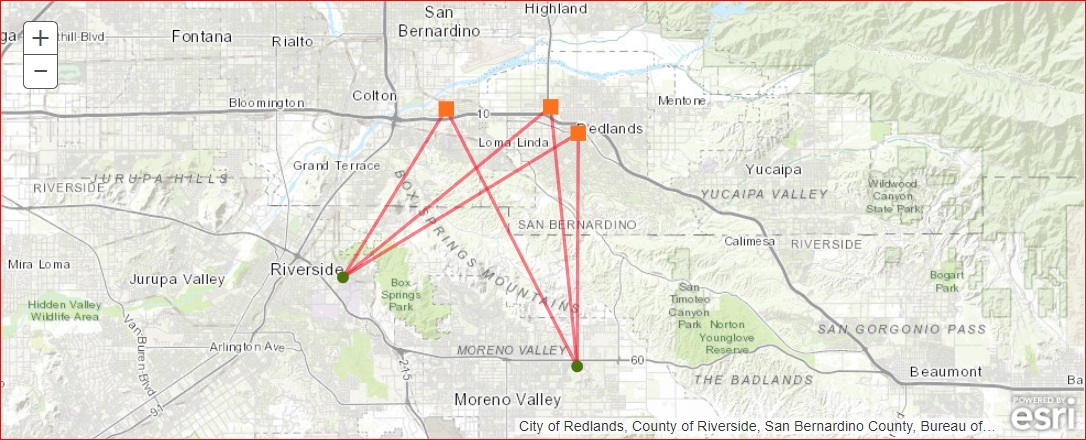

In [10]:
map_view_outputs = my_gis.map('Los Angeles, CA')
map_view_outputs

In [ ]:
map_view_inputs.draw(results.output_origin_destination_lines)
map_view_inputs.draw(destinations_fs_address, symbol={"type": "esriSMS","style": "esriSMSSquare","color": [255,115,0,255], "size": 10})
map_view_inputs.draw(origin_fset, symbol={"type": "esriSMS","style": "esriSMSCircle","color": [76,115,0,255],"size": 8})
